<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1000 non-null   int64 
 1   Patient Id                1000 non-null   object
 2   Age                       1000 non-null   int64 
 3   Gender                    1000 non-null   int64 
 4   Air Pollution             1000 non-null   int64 
 5   Alcohol use               1000 non-null   int64 
 6   Dust Allergy              1000 non-null   int64 
 7   OccuPational Hazards      1000 non-null   int64 
 8   Genetic Risk              1000 non-null   int64 
 9   chronic Lung Disease      1000 non-null   int64 
 10  Balanced Diet             1000 non-null   int64 
 11  Obesity                   1000 non-null   int64 
 12  Smoking                   1000 non-null   int64 
 13  Passive Smoker            1000 non-null   int64 
 14  Chest Pain               

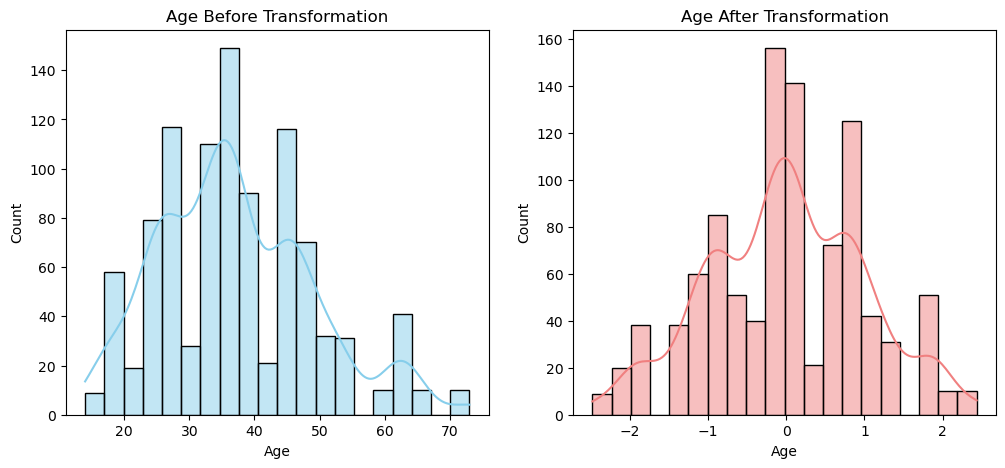

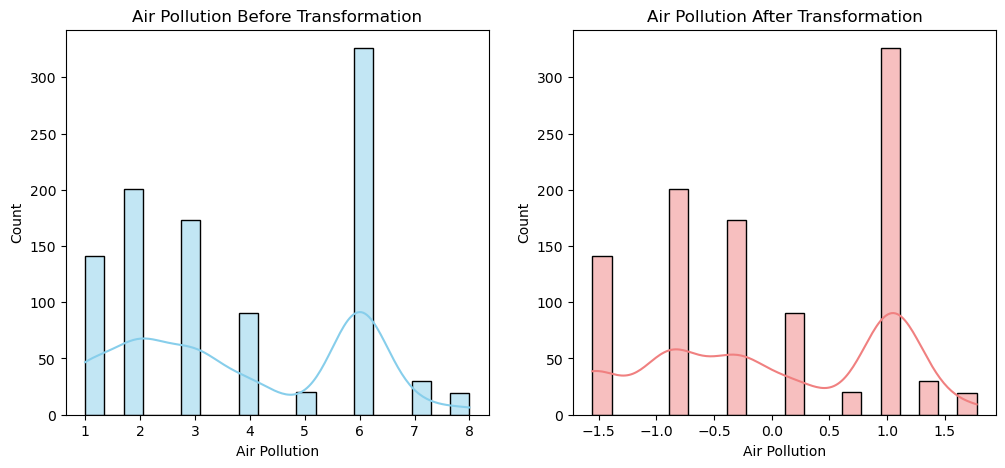

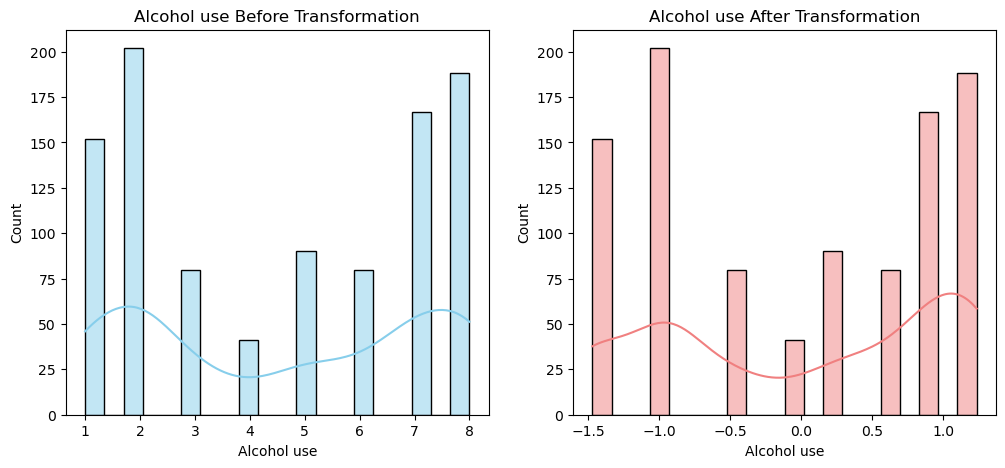

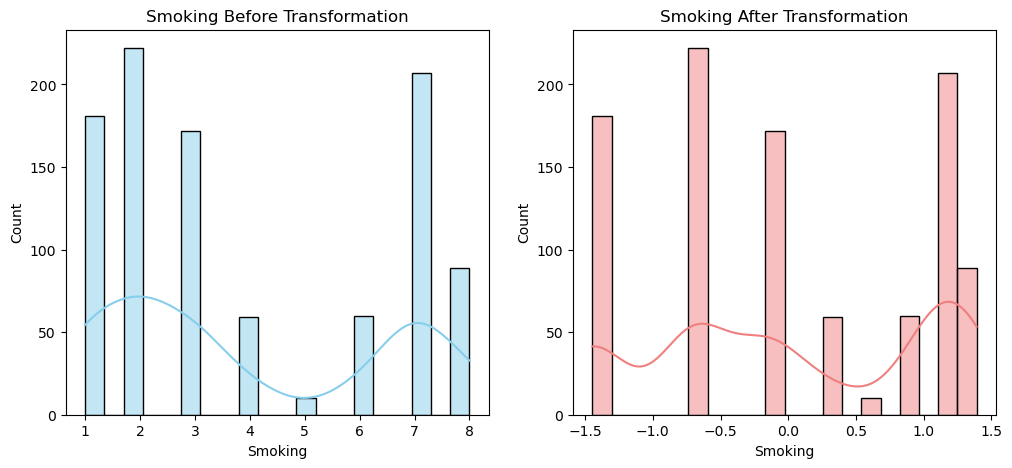

Shape: (1000, 25)


,Level,level_encoded
0,Low,0.0
1,Medium,1.0
2,High,2.0
3,High,2.0
4,High,2.0
5,High,2.0
6,Low,0.0
7,Low,0.0
8,Medium,1.0
9,Medium,1.0


,Level,level_encoded
990,High,2.0
991,High,2.0
992,High,2.0
993,High,2.0
994,High,2.0
995,High,2.0
996,High,2.0
997,High,2.0
998,High,2.0
999,High,2.0


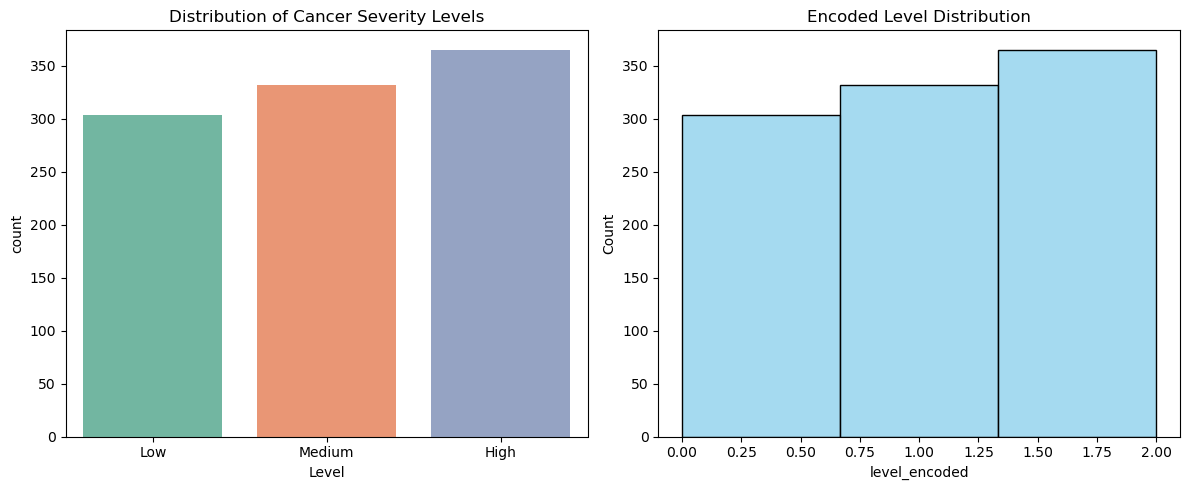

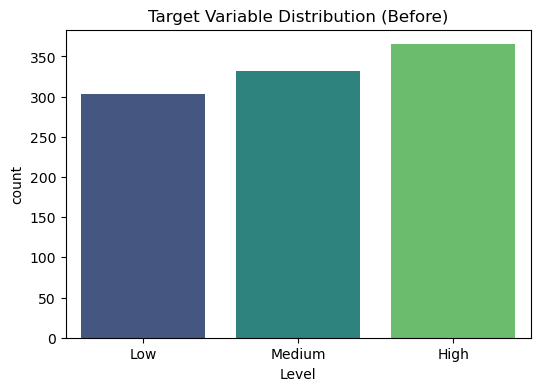

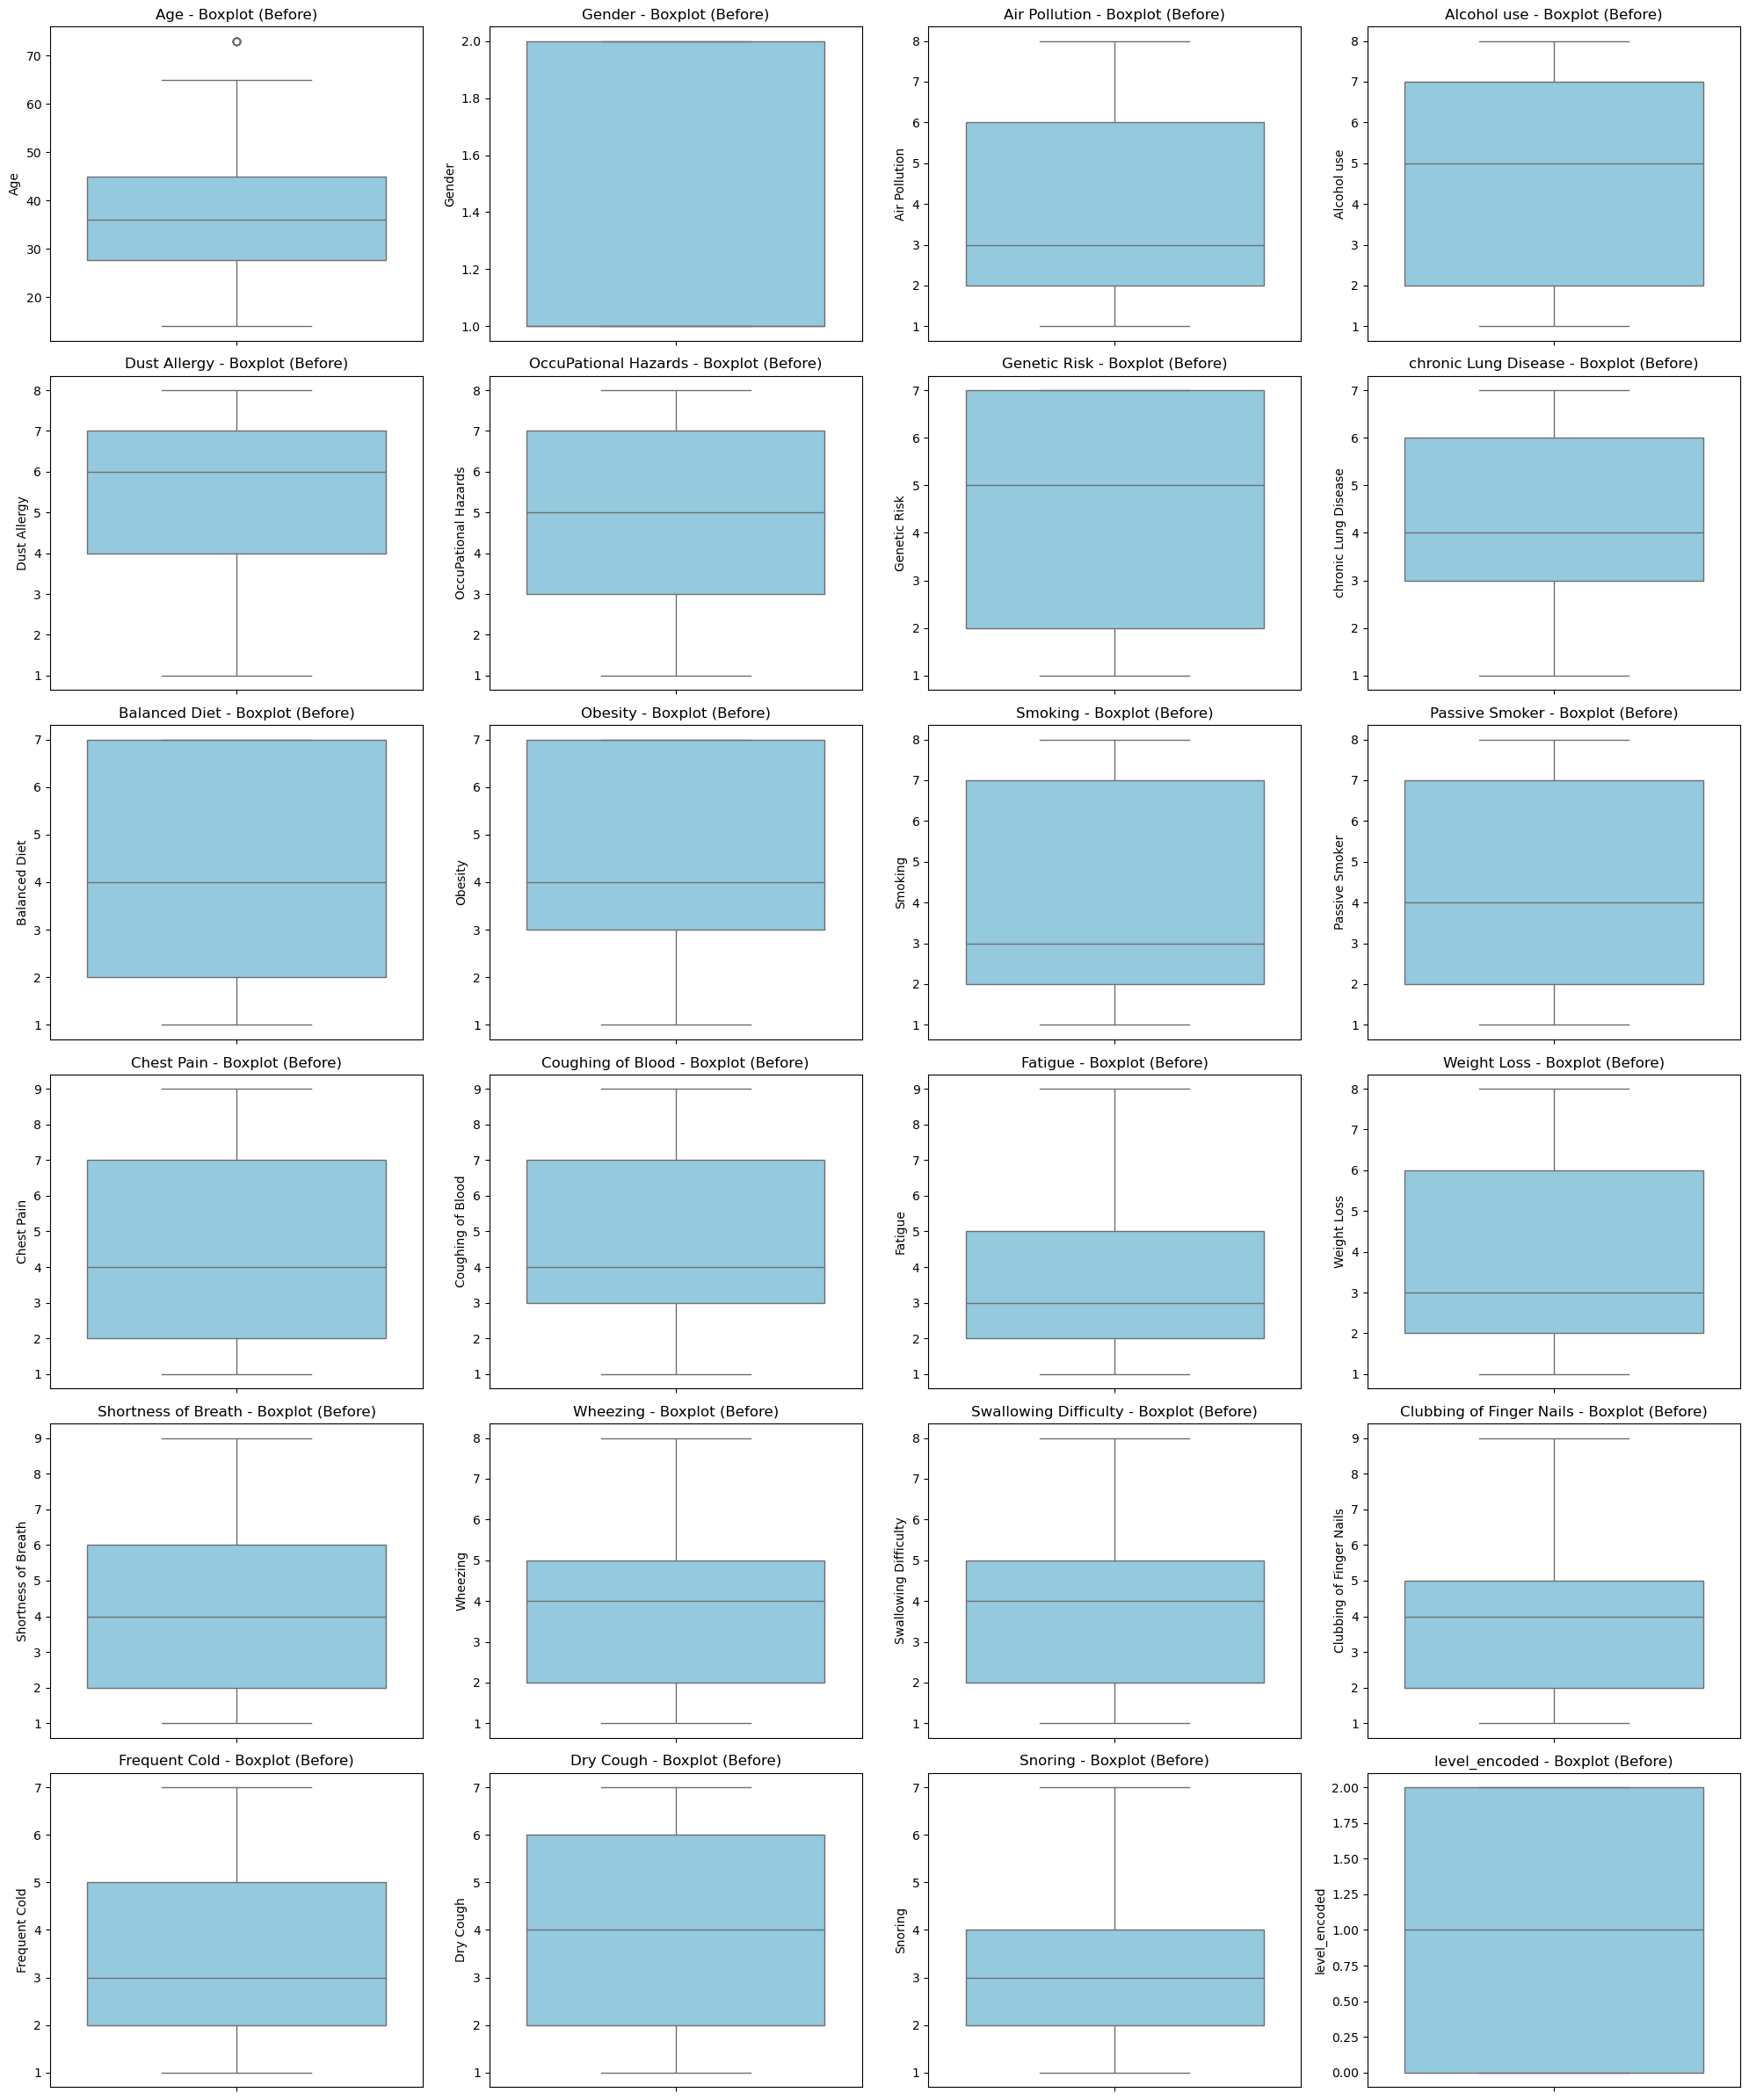

Original dataset shape: (1000, 25)
After IQR outlier removal: (990, 25)


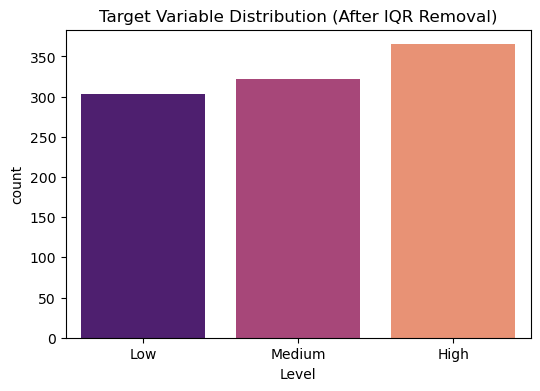

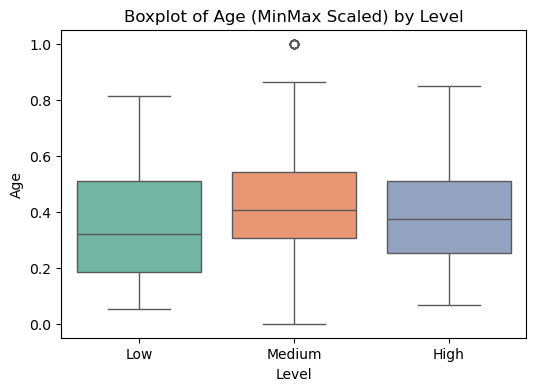

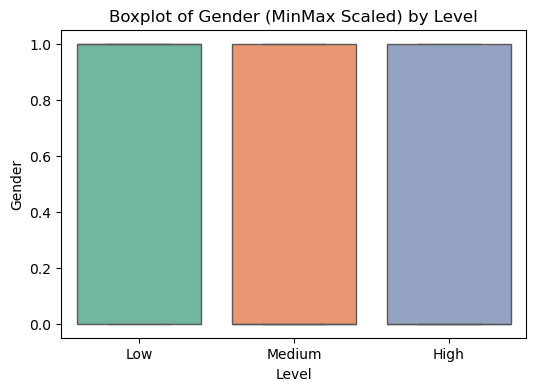

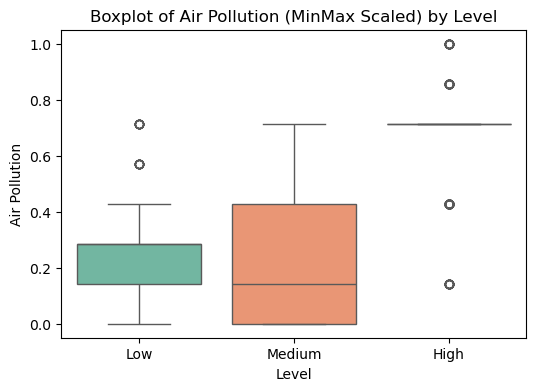

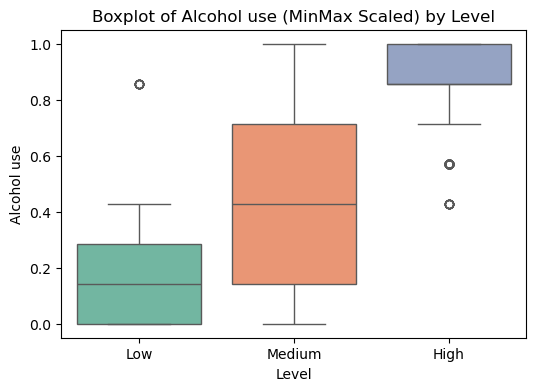

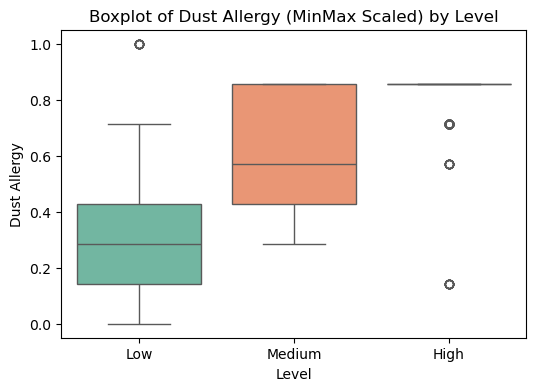

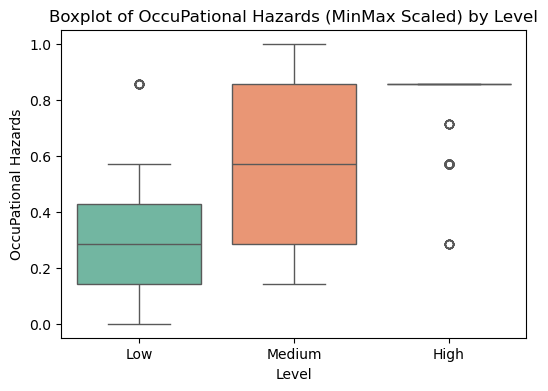

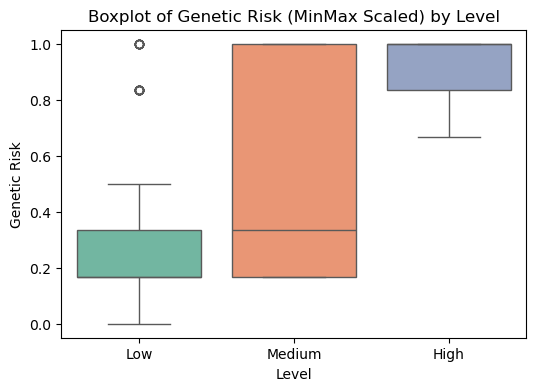

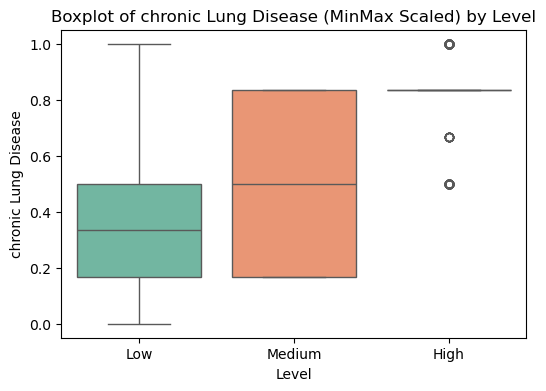

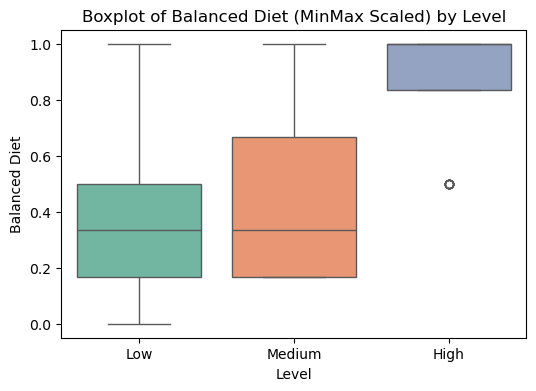

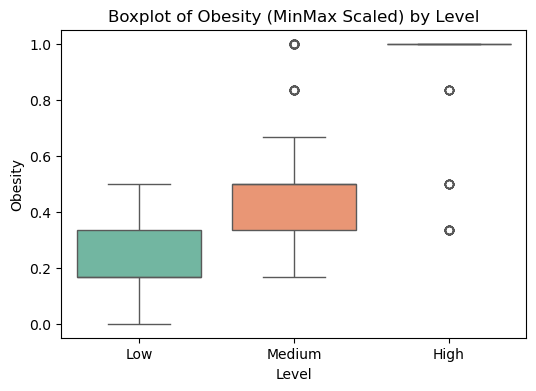

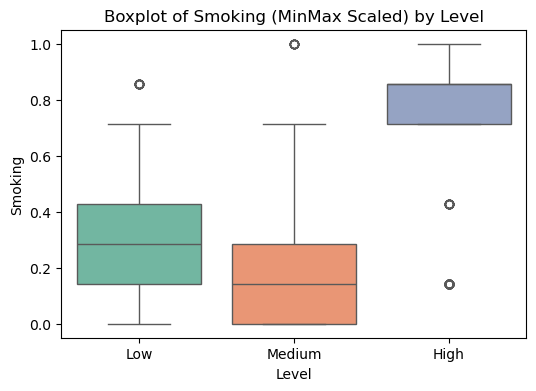

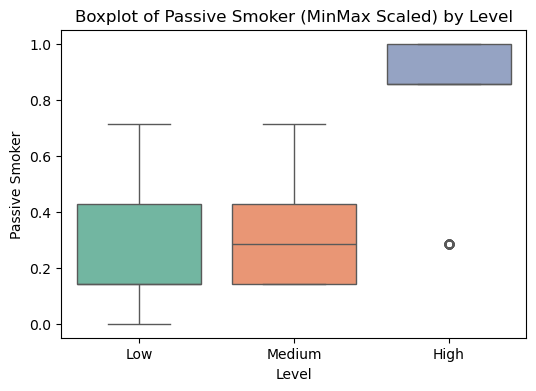

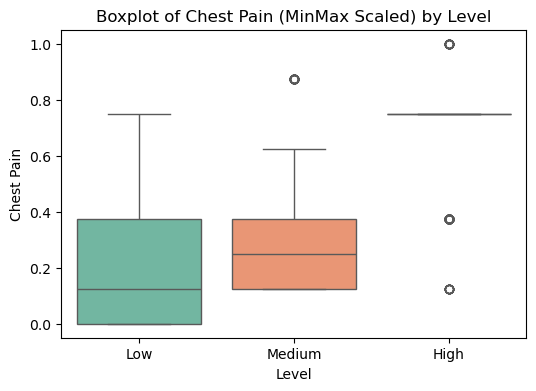

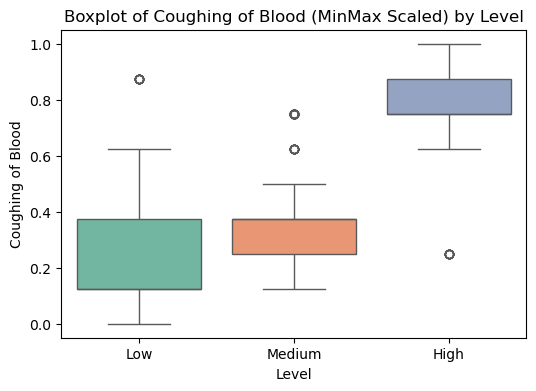

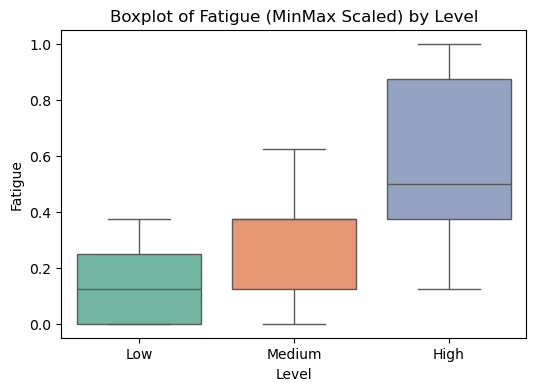

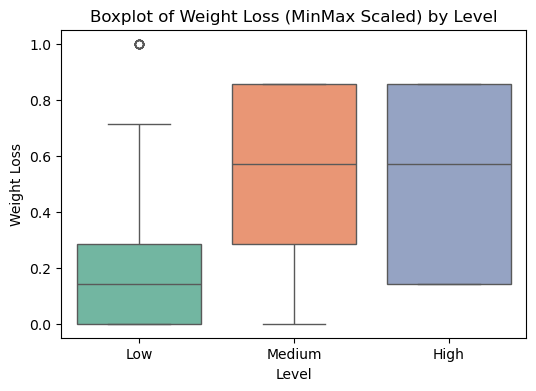

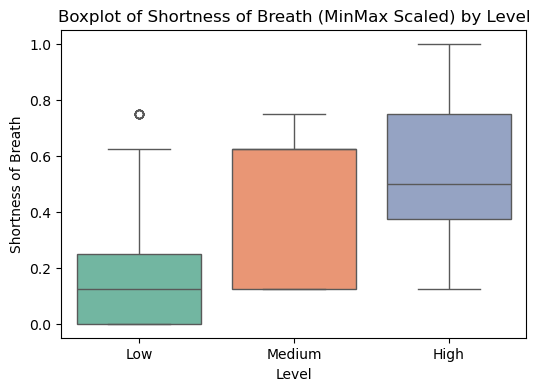

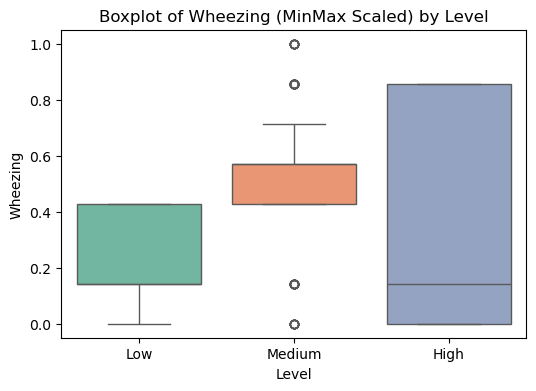

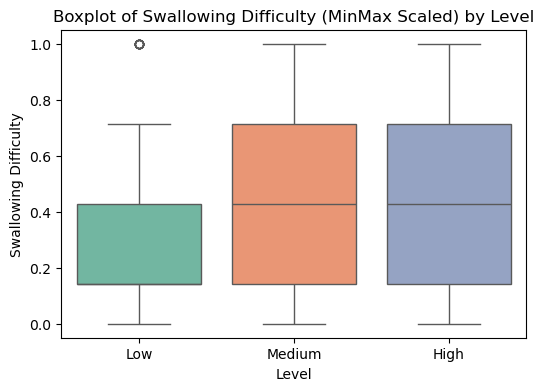

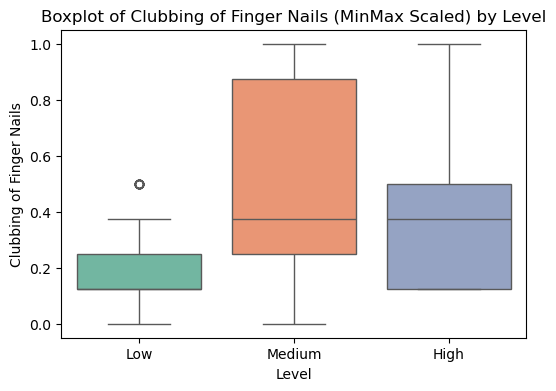

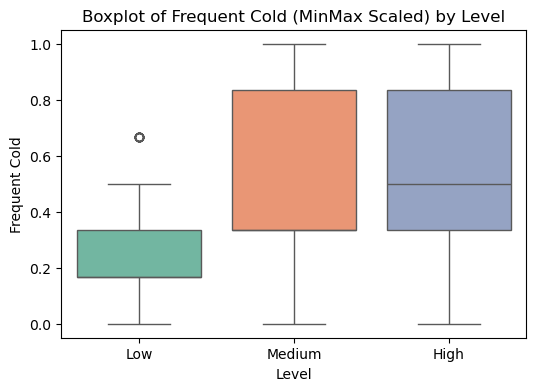

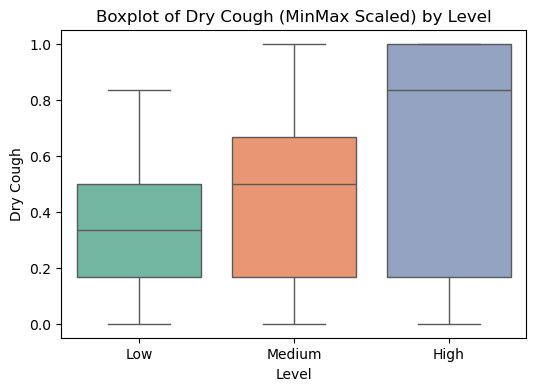

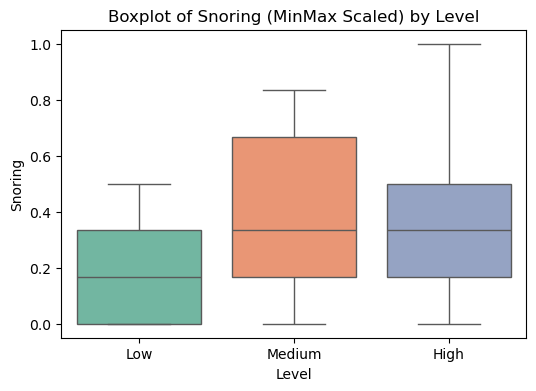

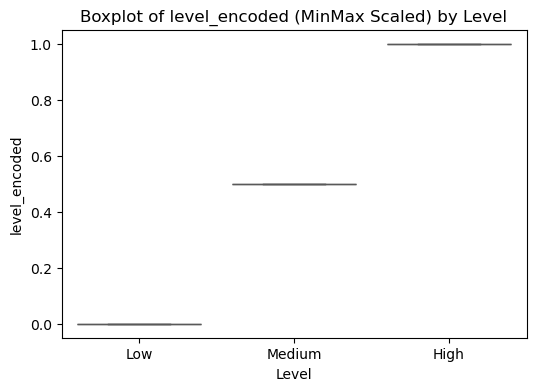

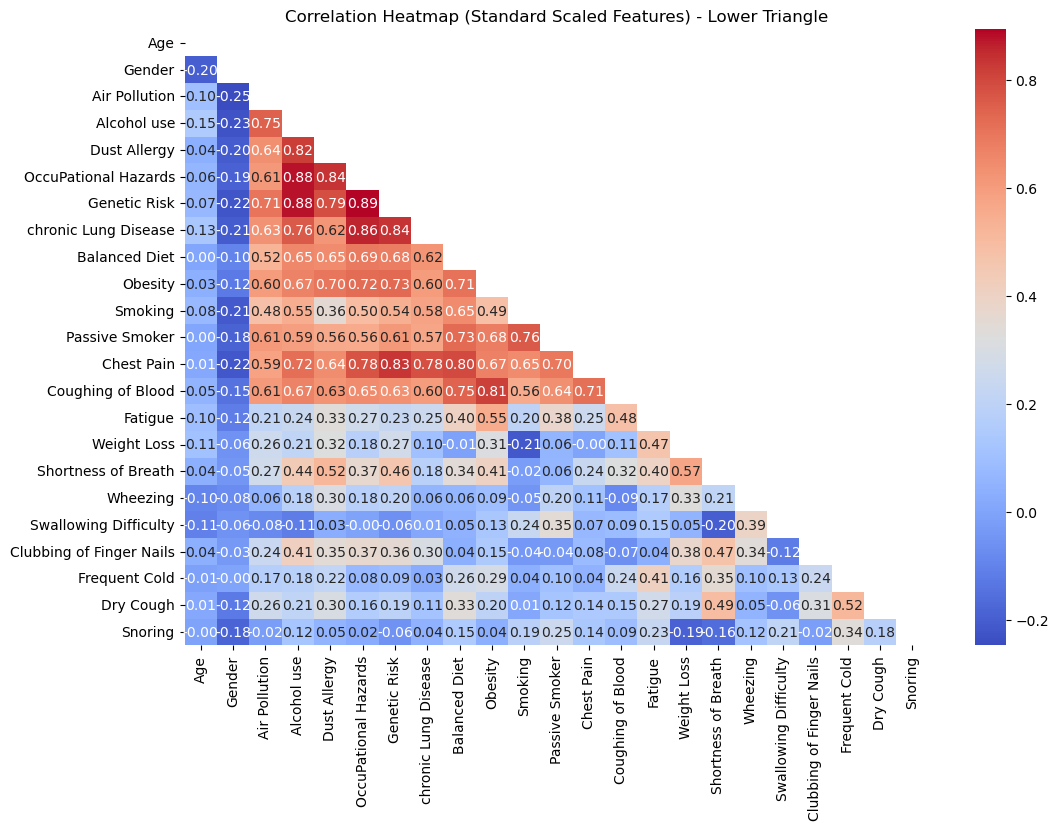

 Top Features Selected:


,Feature,Importance
23,level_encoded,0.238392
13,Coughing of Blood,0.099467
9,Obesity,0.095751
17,Wheezing,0.073721
11,Passive Smoker,0.073610
16,Shortness of Breath,0.036639
8,Balanced Diet,0.034955
12,Chest Pain,0.033772
14,Fatigue,0.031369
2,Air Pollution,0.027955


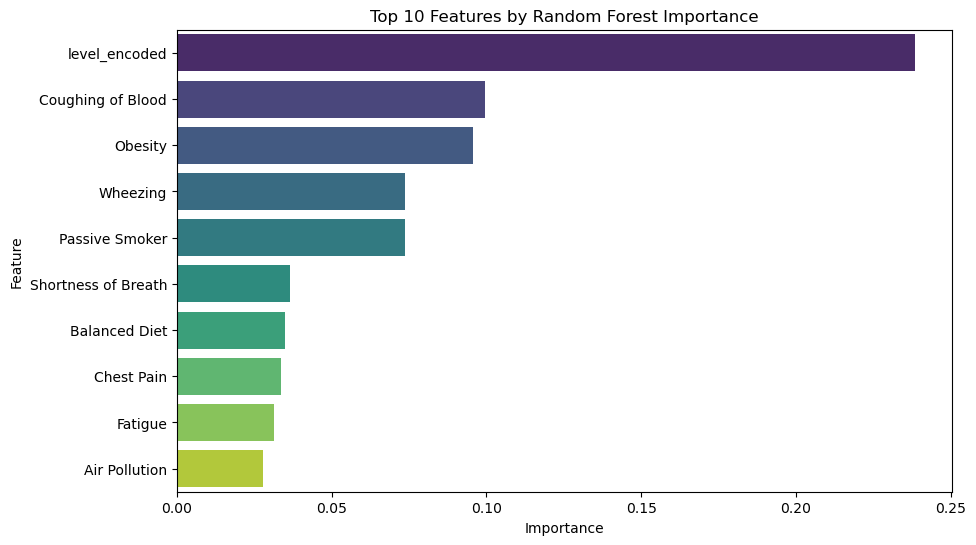

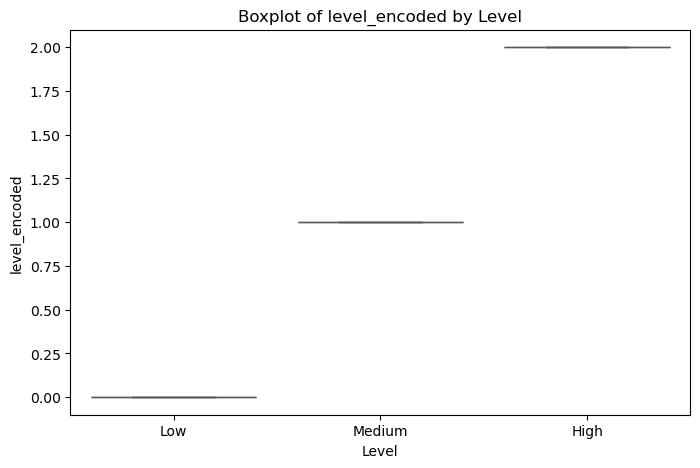

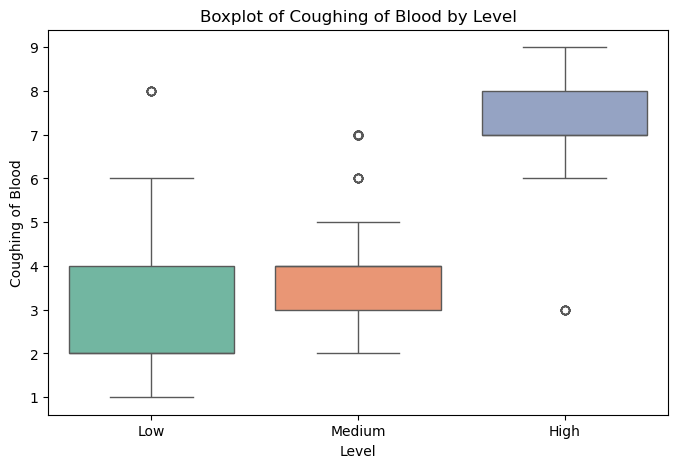

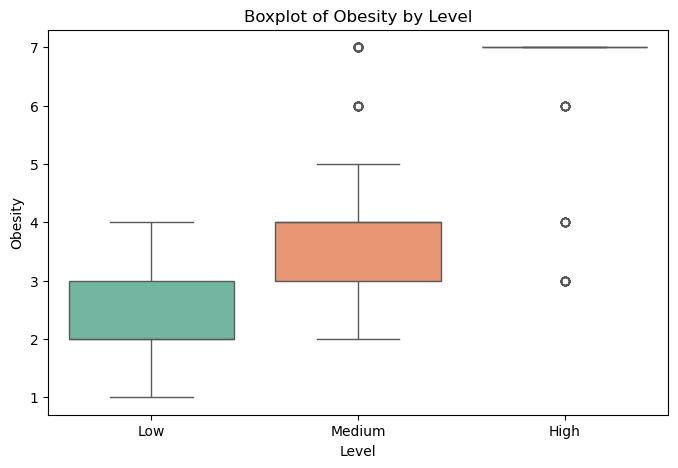

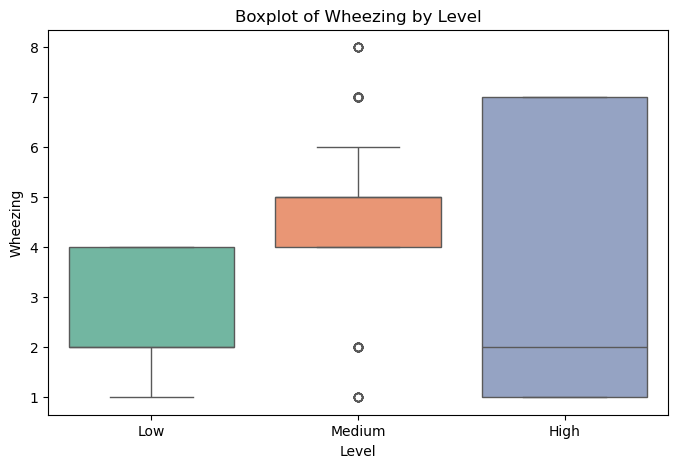

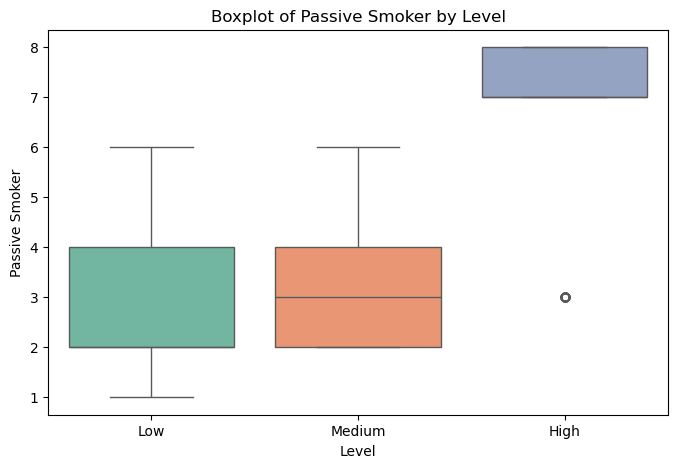

Selected Features: ['num__Alcohol use', 'num__Dust Allergy', 'num__Genetic Risk', 'num__Balanced Diet', 'num__Obesity', 'num__Passive Smoker', 'num__Coughing of Blood', 'num__level_encoded']


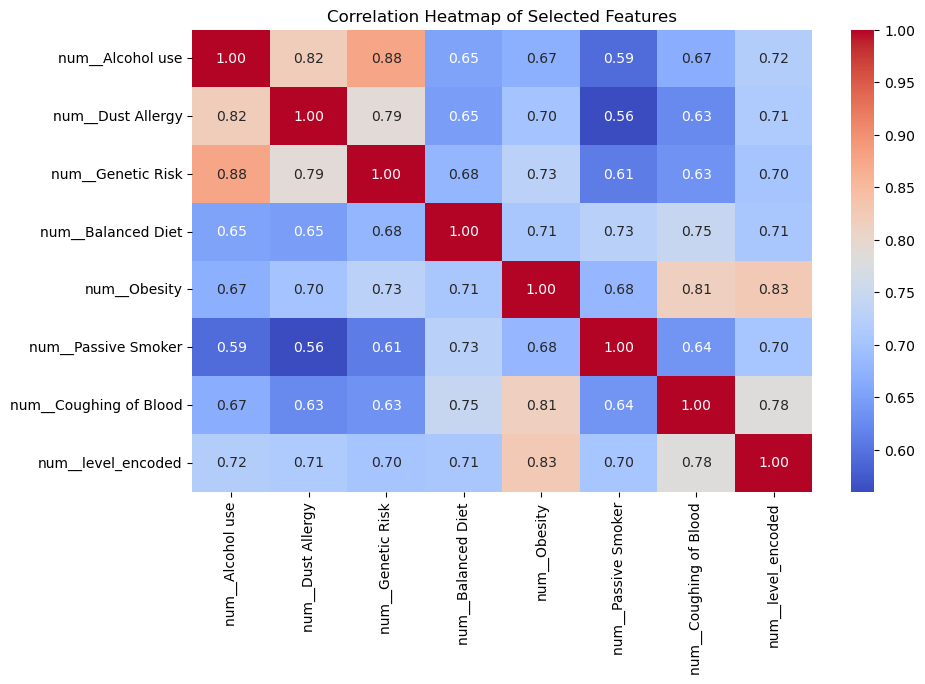

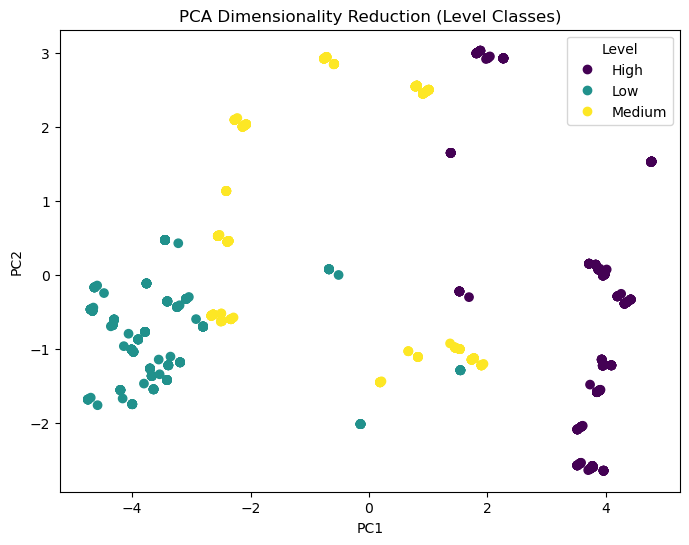

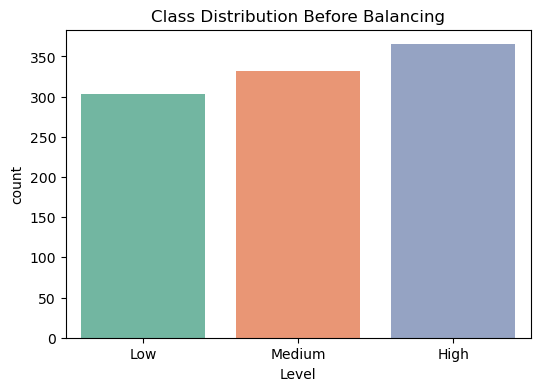

Class distribution:
 Level
High      36.5
Medium    33.2
Low       30.3
Name: proportion, dtype: float64


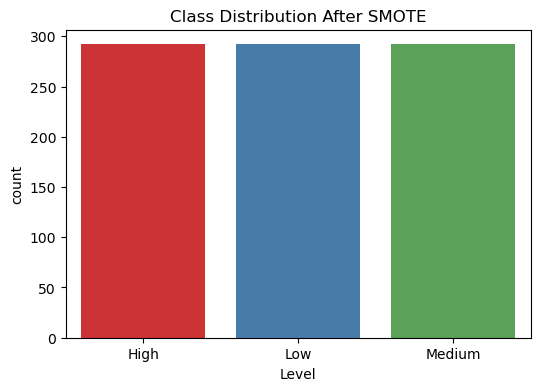

Resampled class distribution:
 Level
High      33.333333
Low       33.333333
Medium    33.333333
Name: proportion, dtype: float64
 Model Accuracy: 0.805

 Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.97      0.99        73
         Low       0.68      0.75      0.71        61
      Medium       0.72      0.67      0.69        66

    accuracy                           0.81       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.81      0.81      0.81       200



In [11]:
# -------Imports Libery------ 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math   # <-- FIXED: for ceil()
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import display


# ------Load Dataset------
df = pd.read_csv("C:\\Users\\Nimesh\\OneDrive\\Desktop\\New folder (2)\\cancer patient data sets (5).csv")

#Handling missing data - IT24101102(Mohotti C.H.)

df.head()

df.info()

df.describe()
# Drop unnecessary columns
df = df.drop(columns=["index", "Patient Id"])


numeric_cols = df.drop(columns=["Level"]).columns
pt = PowerTransformer(method='yeo-johnson')

df_transformed = df.copy()
df_transformed[numeric_cols] = pt.fit_transform(df[numeric_cols])

# Plot histograms before/after
sample_cols = ["Age", "Air Pollution", "Alcohol use", "Smoking"]
for col in sample_cols:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=20, kde=True, color="skyblue")
    plt.title(f"{col} Before Transformation")
    plt.subplot(1,2,2)
    sns.histplot(df_transformed[col], bins=20, kde=True, color="lightcoral")
    plt.title(f"{col} After Transformation")
    plt.show()



# ------- Encoding Categorical Variables -------
df['Level_clean'] = df['Level'].astype(str).str.strip().str.title()
df['Level_clean'] = df['Level_clean'].replace('Nan', np.nan)

categories = [['Low', 'Medium', 'High']]
encoder = OrdinalEncoder(categories=categories)

mask = ~df['Level_clean'].isna()
df['level_encoded'] = np.nan
df.loc[mask, 'level_encoded'] = encoder.fit_transform(
    df.loc[mask, ['Level_clean']]
).flatten()

df = df.drop(columns=['Level_clean'])

print(f"Shape: {df.shape}")
display(df[['Level', 'level_encoded']].head(10))
display(df[['Level', 'level_encoded']].tail(10))

# Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(x="Level", hue="Level", data=df, 
              order=["Low", "Medium", "High"], 
              palette="Set2", ax=axes[0], legend=False)
axes[0].set_title("Distribution of Cancer Severity Levels")
sns.histplot(df["level_encoded"].dropna(), bins=3, kde=False, ax=axes[1], color="skyblue")
axes[1].set_title("Encoded Level Distribution")
plt.tight_layout()
plt.show()



# - Outlier Removal ---------
plt.figure(figsize=(6,4))
sns.countplot(x="Level", data=df, hue="Level", palette="viridis", legend=False)
plt.title("Target Variable Distribution (Before)")
plt.show()

num_cols = df.select_dtypes(include=[np.number]).columns
n = len(num_cols)
rows = math.ceil(n / 4)
cols = 4

plt.figure(figsize=(20, rows*4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(f"{col} - Boxplot (Before)")
plt.tight_layout()
plt.show()

# IQR method
df_iqr_removed = df.copy()
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_iqr_removed = df_iqr_removed[(df_iqr_removed[col] >= lower_bound) & (df_iqr_removed[col] <= upper_bound)]

print("Original dataset shape:", df.shape)
print("After IQR outlier removal:", df_iqr_removed.shape)

plt.figure(figsize=(6,4))
sns.countplot(x="Level", data=df_iqr_removed, hue="Level", palette="magma", legend=False)
plt.title("Target Variable Distribution (After IQR Removal)")
plt.show()




# ----- Normalization / Scaling --------
X = df.drop(columns=["Level"])   
y = df["Level"]

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

scaler_minmax = MinMaxScaler()
X_minmax = X.copy()
X_minmax[numeric_cols] = scaler_minmax.fit_transform(X[numeric_cols])

scaler_std = StandardScaler()
X_std = X.copy()
X_std[numeric_cols] = scaler_std.fit_transform(X[numeric_cols])

df_minmax = X_minmax.copy()
df_minmax["Level"] = y

df_std = X_std.copy()
df_std["Level"] = y

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Level", y=col, data=df_minmax, hue="Level", palette="Set2", legend=False)
    plt.title(f"Boxplot of {col} (MinMax Scaled) by Level")
    plt.show()

# Correlation heatmap
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if "level_encoded" in num_cols:
    num_cols.remove("level_encoded")

mask = np.triu(np.ones_like(df[num_cols].corr(), dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", annot=True, fmt=".2f", mask=mask, cbar=True)
plt.title("Correlation Heatmap (Standard Scaled Features) - Lower Triangle")
plt.show()



# ---------- Feature Importance with Random Forest----------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_rf = df.copy()
for col in df_rf.select_dtypes(include=['object']).columns:
    if col != "Level":
        le = LabelEncoder()
        df_rf[col] = le.fit_transform(df_rf[col])

X = df_rf.drop(columns=["Level"])   
y = df_rf["Level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)

print(" Top Features Selected:")
display(importance_df.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10), hue="Feature", dodge=False, legend=False, palette="viridis")
plt.title("Top 10 Features by Random Forest Importance")
plt.show()

top_features = importance_df.head(5)["Feature"].tolist()
for col in top_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Level", y=col, data=df_rf, hue="Level", dodge=False, legend=False, palette="Set2")
    plt.title(f"Boxplot of {col} by Level")
    plt.show()

# -------Preprocessing & Feature Selection ---------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_classif, k=8))
])

pipeline.fit(X, y)

feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

selected_features = [
    feature_names[i]
    for i, mask in enumerate(pipeline.named_steps["feature_selection"].get_support())
    if mask
]

print("Selected Features:", selected_features)

X_transformed = pipeline.named_steps["preprocessor"].transform(X)

X_transformed_df = pd.DataFrame(
    X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
    columns=feature_names
)

X_selected_df = X_transformed_df[selected_features]

plt.figure(figsize=(10,6))
sns.heatmap(X_selected_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

# ------- PCA -------
from sklearn.decomposition import PCA
X_transformed = preprocessor.fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed)

le = LabelEncoder()
y_numeric = le.fit_transform(y)

plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_numeric, cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Dimensionality Reduction (Level Classes)")
handles, _ = scatter.legend_elements()
plt.legend(handles, le.classes_, title="Level")
plt.show()


# --------- Class Imbalance & SMOTE -----
plt.figure(figsize=(6,4))
sns.countplot(x=y, hue=y, palette="Set2", legend=False)
plt.title("Class Distribution Before Balancing")
plt.show()
print("Class distribution:\n", y.value_counts(normalize=True) * 100)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled, hue=y_train_resampled, palette="Set1", legend=False)
plt.title("Class Distribution After SMOTE")
plt.show()
print("Resampled class distribution:\n", y_train_resampled.value_counts(normalize=True) * 100)

#--------- Accuracy Evaluation -------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_classif, k=8)),
    ("classifier", LogisticRegression(max_iter=1000))
])

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(" Model Accuracy:", acc)
print("\n Classification Report:\n", classification_report(y_test, y_pred))
